Script that takes nr data files, take signal in our direction, taper the start, propagate to the detectors, add noise, inject into detectors, plot.

First some imports

In [ ]:
import bilby 
from bilby.core.prior import Uniform
from bilby.gw.utils import asd_from_freq_series

import numpy as np
import matplotlib
matplotlib.use("Qt5Agg") 
import matplotlib.pyplot as plt
%matplotlib widget
import h5py
import lalsimulation as lalsim
import lal
import os

from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar


/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


Define some helpers:

In [2]:
#some inverse fourier transform helper 
def infft(frequency_domain_strain, sampling_frequency, length=None):
    """ Inverse FFT for use in conjunction with nfft.

    Parameters
    ----------
    frequency_domain_strain: array_like
        Single-sided, normalised FFT of the time-domain strain data (in units
        of strain / Hz).
    sampling_frequency: int, float
        Sampling frequency of the data.
    length: float
        length of the transformed axis of the output.
    """

    time_domain_strain_norm = np.fft.irfft(frequency_domain_strain, n=length)
    time_domain_strain = time_domain_strain_norm * sampling_frequency
    return time_domain_strain


#interpolating to fit our time array
def nr_injection(time):
    """
    This function produces the amplitude for a given 
    NR-derived signal at any given time for a given data file.
    
    Parameters
    ----------
    time : array-like
        A time, or an array of times, at which the amplitudes should be returned.
    datafile : str
        The path to the data file containing the injection.
    """
    
    hp = np.interp(time, times, h_p.data.data)
    hc = np.interp(time, times, h_c.data.data)
    
    return {"plus": hp, "cross": hc}

Some bibly overhead

In [3]:
# Specify the output directory and the name of the simulation.
# bilby setup stuff
outdir = "outdir"
label = "phenomXP"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

Set parameters from NR injection waveform

In [4]:
# Set the binary parameters of the NR inejection waveform
# this is the angle and distance to the source
inclination = 0 #!!!this needs to be 0 for tapering calc
luminosity_distance = 250.
distance = luminosity_distance * lal.PC_SI * 1.0e6
phiRef = 0.0

# our relevant file path - create separate folder system
filepath = 'chombo/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
#filepath = 'chombo/GRChombo_BBSsol02_A17A17q100d17p000_Res40.h5'
#filepath = 'grav_wave_boson_star_testing_gr/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
f = h5py.File(filepath, 'r')

Set up dictionary to store parameters. Populate it

In [5]:
# setting up dict to feed parameters into waveforms
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

# Metadata parameters masses
mtotal = 40.0 # set total mass scale - sim only has relative
# extract masses and convert to different units
m1 = f.attrs['mass1'] #code units
m2 = f.attrs['mass2']

mass_1 = m1 * mtotal / (m1 + m2) #solar masses
mass_2 = m2 * mtotal / (m1 + m2)

# Choose extrinsic parameters

m1SI = mass_1 * lal.MSUN_SI #in kg
m2SI = mass_2 * lal.MSUN_SI

spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(0., mtotal, filepath)
s1x, s1y, s1z = spins[0], spins[1], spins[2]
s2x, s2y, s2z = spins[3], spins[4], spins[5]

# Set sampling frequency of the data segment that we're going to inject the signal into
# just be aware of aliasing issues if too low
sampling_frequency = 4096.0  # Hz
deltaT = 1.0/sampling_frequency #cadence

# we need to set the lowest trustable frequency - set as lowest simulated frequency, scaled by the chosen mass
#CHANGE THIS AFTER DOING THE TAPERING
f_lower = f.attrs['f_lower_at_1MSUN']/mtotal  # this choice generates the whole NR waveforms from the beginning
fRef = 0   #beginning of the waveform
fStart = f_lower


In [6]:
f.close()

Use `lalsim` to generate the waveform polarisations for the injection.

In [7]:
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

approx = lalsim.NR_hdf5

inject_l_modes=[2]
ModeArray = lalsim.SimInspiralCreateModeArray()
for mode in inject_l_modes:
    lalsim.SimInspiralModeArrayActivateAllModesAtL(ModeArray, mode)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ModeArray)

h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

In [8]:
phase = np.arctan2(h_c.data.data, h_p.data.data)
unwrapped_phase = np.unwrap(phase)
unwrapped_phase_interp = UnivariateSpline(times, unwrapped_phase, k=3, s=0)
omega_interp = unwrapped_phase_interp.derivative() 
frequency = omega_interp(times) / (2.0 * np.pi)

safety = 0.1
sol = root_scalar(lambda t1: (1+safety)*(1./t1)-omega_interp(t1)/(2.0*np.pi),
                    x0 = 0.1, 
                    bracket=[0.01, 0.3])
t0, t1 = 0., sol.root
f0, f1 = omega_interp(t0)/(2.0*np.pi), omega_interp(t1)/(2.0*np.pi)
print(f"{t0=:.2e}, {f0=:.2e}, {t1=:.2e}, {f1=:.2e}")

minimum_frequency = f1


t0=0.00e+00, f0=2.66e+01, t1=4.09e-02, f1=2.69e+01


In [9]:
def window(times, t0, t1):
    taper = np.ones_like(times)
    mask = (times >= t0) & (times <= t1)
    taper[mask] = 0.5 * (1 - np.cos(np.pi * (times[mask] - t0) / (t1 - t0)))
    return taper

In [10]:
taper = window(times, t0, t1)

tapered_hp = h_p.data.data * taper
tapered_hc = h_c.data.data * taper

We plot the results

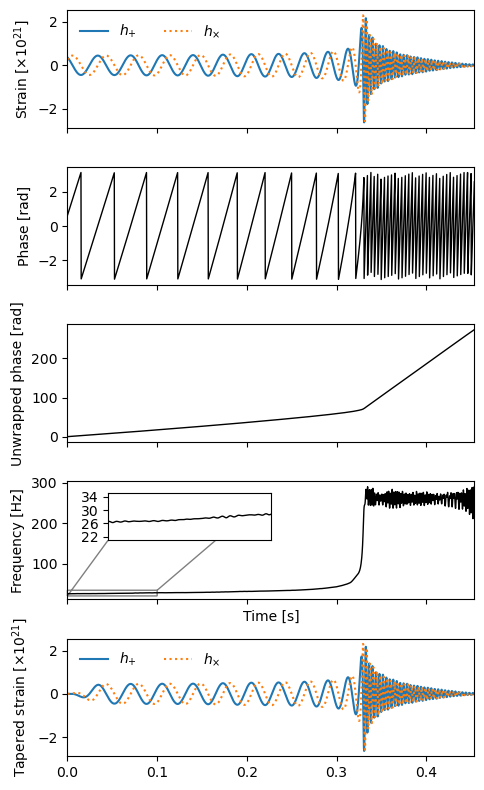

In [11]:
fig, axes = plt.subplots(nrows=5, sharex=True, figsize=(5, 8))

# plot initial signal
axes[0].plot(times, 1.0e21*h_p.data.data, ls='-', label=r'$h_{+}$')
axes[0].plot(times, 1.0e21*h_c.data.data, ls=':', label=r'$h_{\times}$')
axes[0].set_ylabel(r'Strain [$\times 10^{21}$]')
axes[0].set_xlim(times[0], times[-1])
axes[0].legend(loc='upper left', frameon=False, ncols=2)

# plot phase
axes[1].plot(times, phase, 'k-', lw=1)
axes[1].set_ylabel('Phase [rad]')

# unwrapped phase
axes[2].plot(times, unwrapped_phase, 'k-', lw=1)
axes[2].set_ylabel('Unwrapped phase [rad]')

# frequency
axes[3].plot(times, frequency, 'k-', lw=1)
axes[3].set_xlabel('Time [s]')
axes[3].set_ylabel('Frequency [Hz]')

# zoomed frequency window
x1, x2, y1, y2 = 0.0, 0.1, 21.0, 35.0  # subregion of the original image
axins = axes[3].inset_axes(
    [0.1, 0.5, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[], yticks=np.arange(22., 36.1, 4.))
axins.plot(times, frequency, 'k-', lw=1)
axes[3].indicate_inset_zoom(axins, edgecolor="black")

# after tapering
axes[4].plot(times, 1.0e21*tapered_hp, ls='-', label=r'$h_{+}$')
axes[4].plot(times, 1.0e21*tapered_hc, ls=':', label=r'$h_{\times}$')
axes[4].set_ylabel(r'Tapered strain [$\times 10^{21}$]')
axes[4].set_xlim(times[0], times[-1])
axes[4].legend(loc='upper left', frameon=False, ncols=2)

plt.tight_layout()
plt.show()

In [12]:
# Replace the waveform data in-place with the tapered arrays
original_hp = np.copy(h_p.data.data)
original_hc = np.copy(h_c.data.data)

h_p.data.data[:] = tapered_hp
h_c.data.data[:] = tapered_hc

Plots for sanity check:

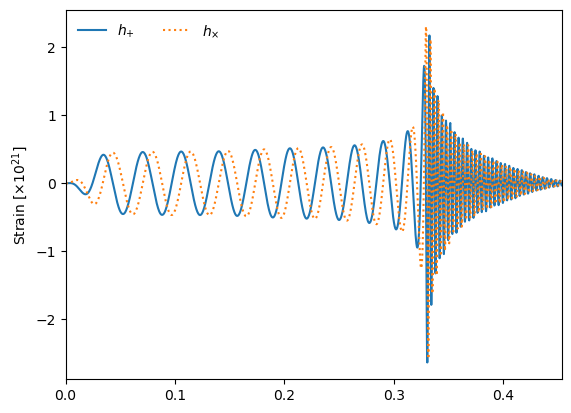

In [13]:
fig = plt.figure()
plt.plot(times, 1.0e21*h_p.data.data, ls='-', label=r'$h_{+}$')
plt.plot(times, 1.0e21*h_c.data.data, ls=':', label=r'$h_{\times}$')
plt.ylabel(r'Strain [$\times 10^{21}$]')
plt.xlim(times[0], times[-1])
plt.legend(loc='upper left', frameon=False, ncols=2)
plt.show()
fig.clear()

Then, do the rest of the injection and plot the final signal so we can see how the fourier did

Find peak time for analysis later

In [14]:
amplitude = []

for i in range(len(h_p.data.data)):
    amp = np.sqrt(h_p.data.data[i] * h_p.data.data[i] + h_c.data.data[i] * h_c.data.data[i])
    amplitude.append(amp)
    
peak_id = amplitude.index(max(amplitude))
peak = times[peak_id]

print("I am at peak at value: ", peak)

hplus = h_p.data.data[peak_id]
hcross = h_c.data.data[peak_id]
print("hplus at peak: ", hplus)
print("hcross at peak: ", hcross)

I am at peak at value:  0.330810546875
hplus at peak:  -2.4092294885361834e-21
hcross at peak:  -1.1167194383608317e-21


In [15]:
# the phase when they merge
phase_merger = np.arctan2(-hcross,hplus) + np.pi

print("arctan(-hcross/hplus): ", np.arctan2(-hcross,hplus))
print("Phase at coalescence: ", phase_merger)

# Set the duration of the data segment that we're
# going to inject the signal into
duration = times[-1]
print("Duration of the signal equals: ", duration)

arctan(-hcross/hplus):  2.707554809013698
Phase at coalescence:  5.849147462603491
Duration of the signal equals:  0.453369140625


In [16]:
# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

# We first establish a  dictionary of parameters that includes all of the different waveform
# parameters, including masses (mass_1, mass_2),  spins (a, tilt, phi), etc.
# this is to create the signal propagating through the detectors
injection_parameters = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0.0,
    phi_jl=0.0,
    luminosity_distance=luminosity_distance,
    theta_jn=inclination,
    psi=np.pi/2,
    phase=phase_merger,
    geocent_time=peak,
    ra=1.375,
    dec=-1.2108)

15:39 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})


/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


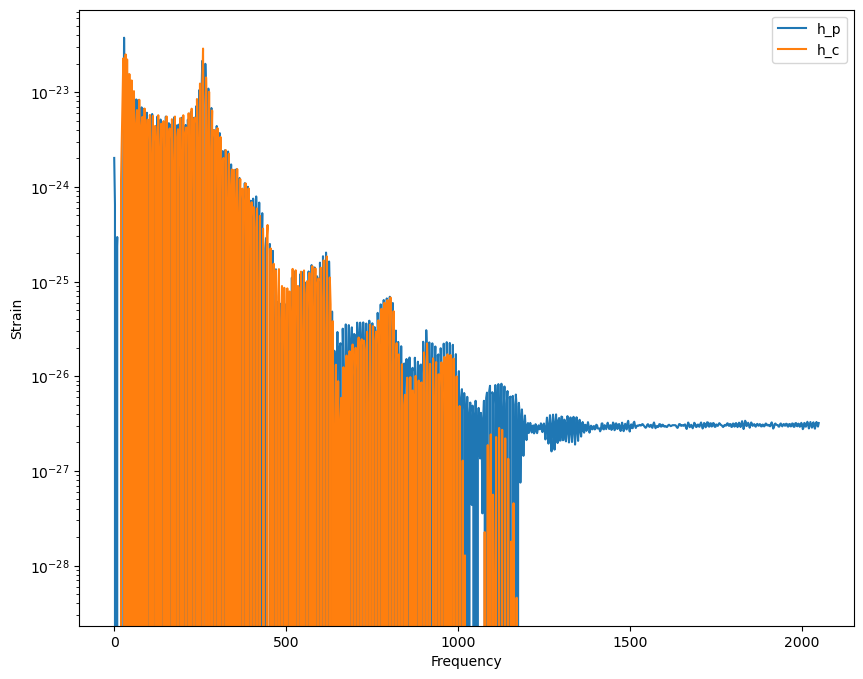

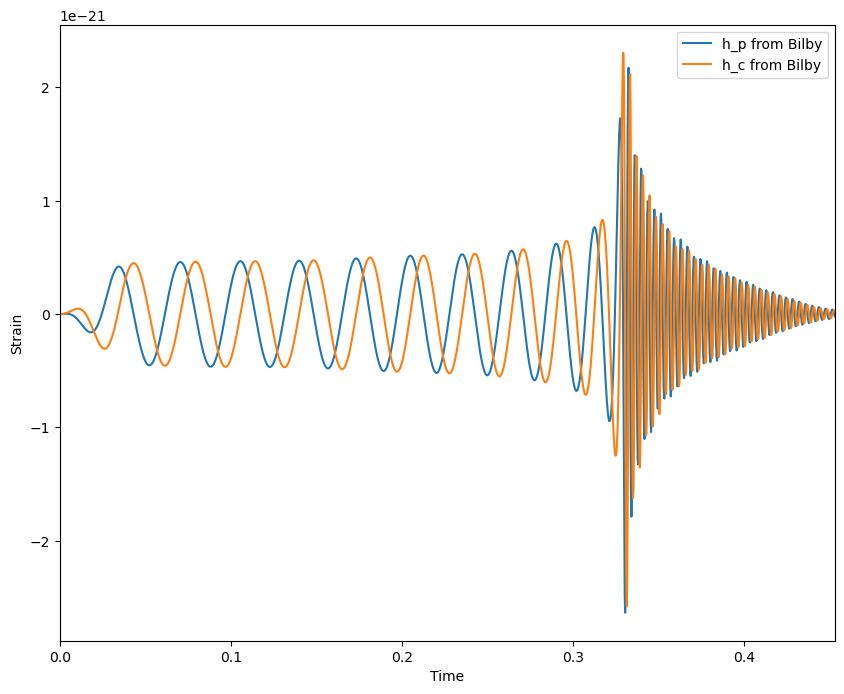

In [17]:
# create signal as it reaches the detectors / propagate signal to detectors
# call the waveform_generator to create our waveform model.
waveform = bilby.gw.waveform_generator.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=nr_injection, start_time=0.0)

# get out the strain in the time and frequency domains
time_domain = waveform.time_domain_strain(parameters=injection_parameters)
time_array = waveform.time_array

fr_domain = waveform.frequency_domain_strain(parameters=injection_parameters)
fr_array = waveform.frequency_array

#Some plotting routines for sanity check and visuals
plt.figure(figsize=(10,8))
plt.plot(fr_array, fr_domain["plus"], label="h_p")
plt.plot(fr_array, fr_domain["cross"], label="h_c")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.yscale('log')
plt.legend()
plt.savefig("outdir/waveform_frequency_domain.pdf")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(time_array, time_domain["plus"], label="h_p from Bilby")
plt.plot(time_array, time_domain["cross"], label="h_c from Bilby")
plt.xlim(time_array[0], time_array[-1])
plt.xlabel("Time")
plt.ylabel("Strain")
plt.legend()
plt.savefig("outdir/waveform_time_domain.pdf")
plt.show()

15:39 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:39 bilby INFO    : Injected signal in H1:
15:39 bilby INFO    :   optimal SNR = 70.14
15:39 bilby INFO    :   matched filter SNR = 70.59+0.39j
15:39 bilby INFO    :   mass_1 = 20.0
15:39 bilby INFO    :   mass_2 = 20.0
15:39 bilby INFO    :   a_1 = 0.0
15:39 bilby INFO    :   a_2 = 0.0
15:39 bilby INFO    :   tilt_1 = 0.0
15:39 bilby INFO    :   tilt_2 = 0.0
15:39 bilby INFO    :   phi_12 = 0.0
15:39 bilby INFO    :   phi_jl = 0.0
15:39 bilby INFO    :   luminosity_distance = 250.0
15:39 bilby INFO    :   theta_jn = 0
15:39 bilby INFO    :   psi = 1.5707963267948966
15:39 bilby INFO    :   phase = 5.849147462603491
15:39 bilby INFO    :   geocent_time = 0.330810546875
15:39 bilby INFO    :   ra = 1.375
15:39 bilby INFO    :   dec = -1.2108
15:39 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector L1 has a d

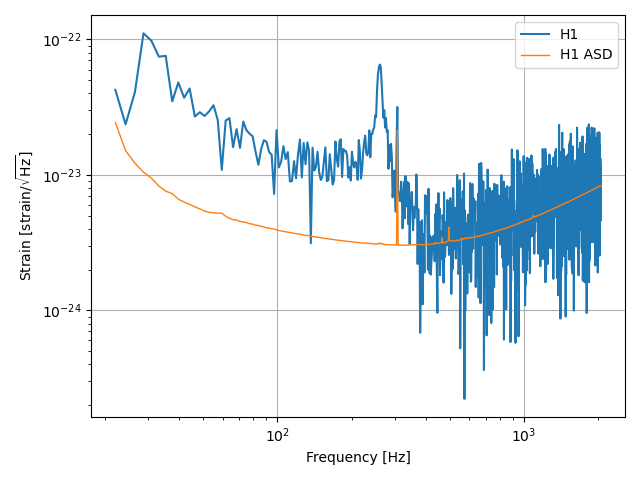

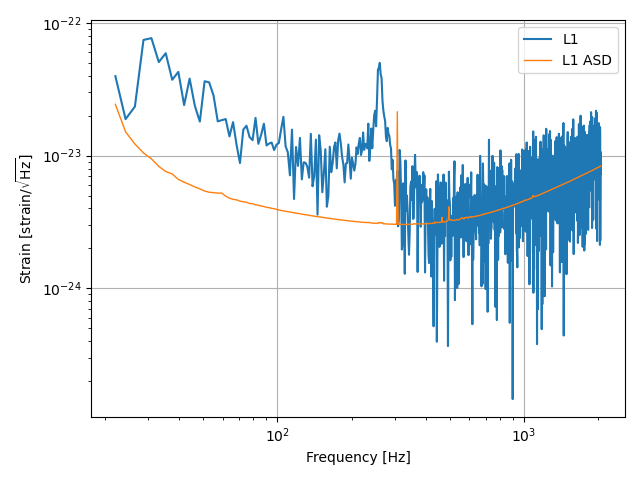

In [18]:
# inject the signal into three interferometers and add noise
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=0.)
ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters, raise_error=False);

ifos.plot_data(label="post_injection")
from IPython.display import Image, display
display(Image(filename="H1_post_injection_frequency_domain_data.png"))
display(Image(filename="L1_post_injection_frequency_domain_data.png"))

Now we want to generate the relevant datasets to at least get a new strain timeseries

In [19]:
# Generate some intermmediate plot files
# these are different versions of datafiles, prob wont need most of them
start_time = 0
end_time = duration

for ifo in ifos:
    time_idxs = (
                (ifo.time_array >= start_time) &
                (ifo.time_array <= end_time)
            ) #returns a boolean array of interferometer time

    frequency_idxs = np.where(ifo.frequency_mask)[0]
    frequency_idxs = frequency_idxs[::max(1, len(frequency_idxs) // 4000)]
    plot_times = ifo.time_array[time_idxs]
    plot_frequencies = ifo.frequency_array[frequency_idxs]

    frequency_window_factor = (
                np.sum(ifo.frequency_mask)
                / len(ifo.frequency_mask)
            ) # create a window factor using a masking array for limiting the frequency band 
    hf_d = asd_from_freq_series(
                ifo.frequency_domain_strain[frequency_idxs],
                1 / ifo.strain_data.duration)
    ht_d = np.fft.irfft(ifo.whitened_frequency_domain_strain
                            * np.sqrt(np.sum(ifo.frequency_mask))
                            / frequency_window_factor, n=len(time_idxs)
                        )[time_idxs]
    
    # Save data stream here
    np.savetxt("outdir/"+ifo.name+"_time_data_stream.dat", np.column_stack([plot_times, ht_d]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_data_stream.dat", np.column_stack([plot_frequencies, ifo.frequency_domain_strain[frequency_idxs]]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_asd_data_stream.dat", np.column_stack([plot_frequencies, hf_d]), delimiter='   ')

    hf_inj = waveform.frequency_domain_strain(injection_parameters)
    hf_inj_det = ifo.get_detector_response(hf_inj, injection_parameters)
    ht_inj_det = infft(hf_inj_det * np.sqrt(2. / ifo.sampling_frequency) /
                            ifo.amplitude_spectral_density_array,
                            sampling_frequency, len(time_idxs))[time_idxs]

    # Save injections to file 
    np.savetxt("outdir/"+ifo.name+"_time_injection_waveform.dat", np.column_stack([plot_times, ht_inj_det]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_injection_waveform.dat", np.column_stack([plot_frequencies, hf_inj_det[frequency_idxs]]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_asd_injection_waveform.dat", np.column_stack([plot_frequencies, asd_from_freq_series(hf_inj_det[frequency_idxs], 1 / ifo.strain_data.duration)]), delimiter='   ')

/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_91965/2790042132.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[4].legend()


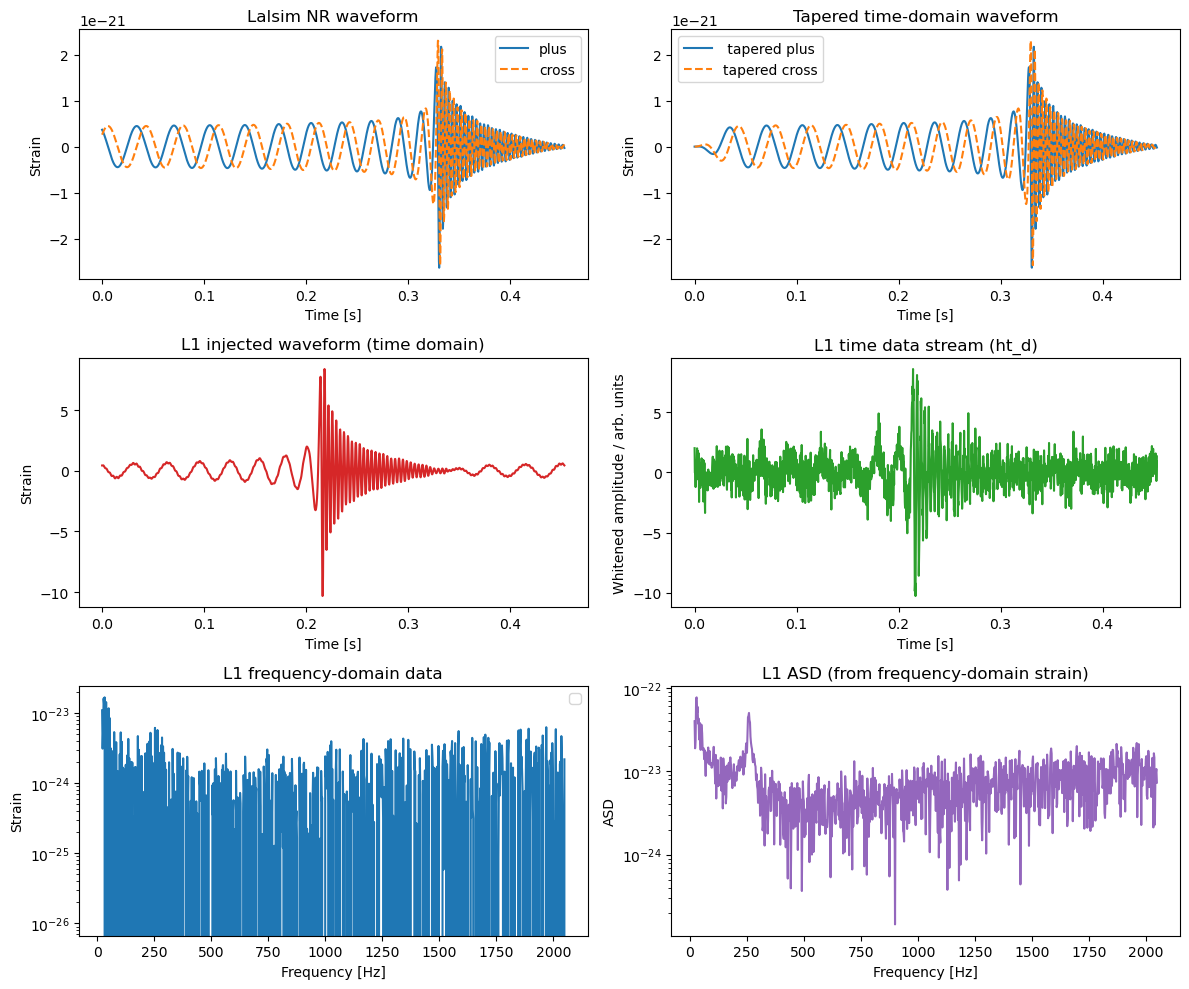

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
ax = axes.flatten()

# 2) Lalsim NR waveform (plus & cross)
ax[0].plot(times, original_hp, label="plus")
ax[0].plot(times, original_hc, ls="--", label="cross")
ax[0].set_title("Lalsim NR waveform")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")
ax[0].legend()

# 2) Tapered time-domain waveform (plus & cross)
ax[1].plot(time_array, time_domain["plus"], label=" tapered plus")
ax[1].plot(time_array, time_domain["cross"], ls="--", label="tapered cross")
ax[1].set_title("Tapered time-domain waveform")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Strain")
ax[1].legend()

# 3) Detector injected time-series (ht_inj_det)
ax[2].plot(plot_times, ht_inj_det, color="C3")
ax[2].set_title(f"{ifo.name} injected waveform (time domain)")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Strain")

# 4) Detector time-series (ht_d)
ax[3].plot(plot_times, ht_d, color="C2")
ax[3].set_title(f"{ifo.name} time data stream (ht_d)")
ax[3].set_xlabel("Time [s]")
ax[3].set_ylabel("Whitened amplitude / arb. units")

# 5) Detector frequency-domain data
ax[4].plot(plot_frequencies, ifo.frequency_domain_strain[frequency_idxs])
ax[4].set_yscale("log")
ax[4].set_title(f"{ifo.name} frequency-domain data")
ax[4].set_xlabel("Frequency [Hz]")
ax[4].set_ylabel("Strain")
ax[4].legend()

# 6) ASD from interferometer frequency-domain strain (subset used for plotting)
ax[5].plot(plot_frequencies, hf_d, color="C4")
ax[5].set_yscale("log")
ax[5].set_title(f"{ifo.name} ASD (from frequency-domain strain)")
ax[5].set_xlabel("Frequency [Hz]")
ax[5].set_ylabel("ASD")

plt.tight_layout()
plt.show()

Now we might have to save more metadata to pass to ringdown later